In [43]:
# Tahap 1: Persiapan dan Import Libraries

# Import libraries yang diperlukan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Untuk metode 2SLS
from statsmodels.sandbox.regression.gmm import IV2SLS
from statsmodels.tools.tools import add_constant
import statsmodels.api as sm

# Untuk Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


Library ini mencakup statsmodels untuk estimasi 2SLS dan sklearn untuk implementasi machine learning

In [44]:
#Tahap 2: Load dan Merge Dataset

# Load semua dataset
df_rls = pd.read_csv('bps-od_15058_rata_rata_lama_sekolah__prov_di_indonesia_v3_data.csv')
df_miskin = pd.read_csv("bps-od_20948_persentase_penduduk_miskin__prov_di_indonesia_v2_data.csv")
df_ipm = pd.read_csv('bps-od_15042_indeks_pmbngnn_manusia__prov_di_indonesia_data.csv')
df_pdrb = pd.read_csv('bps-od_20211_produk_dmstk_regional_bruto_pdrb_per_kapita_dasar__data.csv')

# Pilih kolom yang relevan dan rename untuk kemudahan
df_rls = df_rls[['kode_provinsi', 'nama_provinsi', 'rata_rata_lama_sekolah', 'tahun']]
df_miskin = df_miskin[['kode_provinsi', 'nama_provinsi', 'persentase_penduduk_miskin', 'tahun']]
df_ipm = df_ipm[['kode_provinsi', 'nama_provinsi', 'indeks_pembangunan_manusia', 'tahun']]
df_pdrb = df_pdrb[['kode_provinsi', 'nama_provinsi', 'pdrb_per_kapita', 'tahun']]

# Merge semua dataset berdasarkan kode_provinsi dan tahun
df_merged = df_rls.merge(df_ipm, on=['kode_provinsi', 'nama_provinsi', 'tahun'], how='inner')
df_merged = df_merged.merge(df_miskin, on=['kode_provinsi', 'nama_provinsi', 'tahun'], how='inner')
df_merged = df_merged.merge(df_pdrb, on=['kode_provinsi', 'nama_provinsi', 'tahun'], how='inner')

# Hapus missing values
df_merged = df_merged.dropna()

print("Dimensi dataset gabungan:", df_merged.shape)
print("\nInformasi dataset:")
print(df_merged.info())
print("\nStatistik deskriptif:")
print(df_merged.describe())


Dimensi dataset gabungan: (310, 7)

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 310 entries, 0 to 309
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   kode_provinsi               310 non-null    int64  
 1   nama_provinsi               310 non-null    object 
 2   rata_rata_lama_sekolah      310 non-null    float64
 3   tahun                       310 non-null    int64  
 4   indeks_pembangunan_manusia  310 non-null    float64
 5   persentase_penduduk_miskin  310 non-null    float64
 6   pdrb_per_kapita             310 non-null    float64
dtypes: float64(4), int64(2), object(1)
memory usage: 17.1+ KB
None

Statistik deskriptif:
       kode_provinsi  rata_rata_lama_sekolah        tahun  \
count     310.000000              310.000000   310.000000   
mean       48.170968                8.589871  2020.051613   
std        26.530067                1.000945     2.608

Kode ini menggabungkan keempat dataset berdasarkan provinsi dan tahun untuk analisis sistem persamaan simultan.

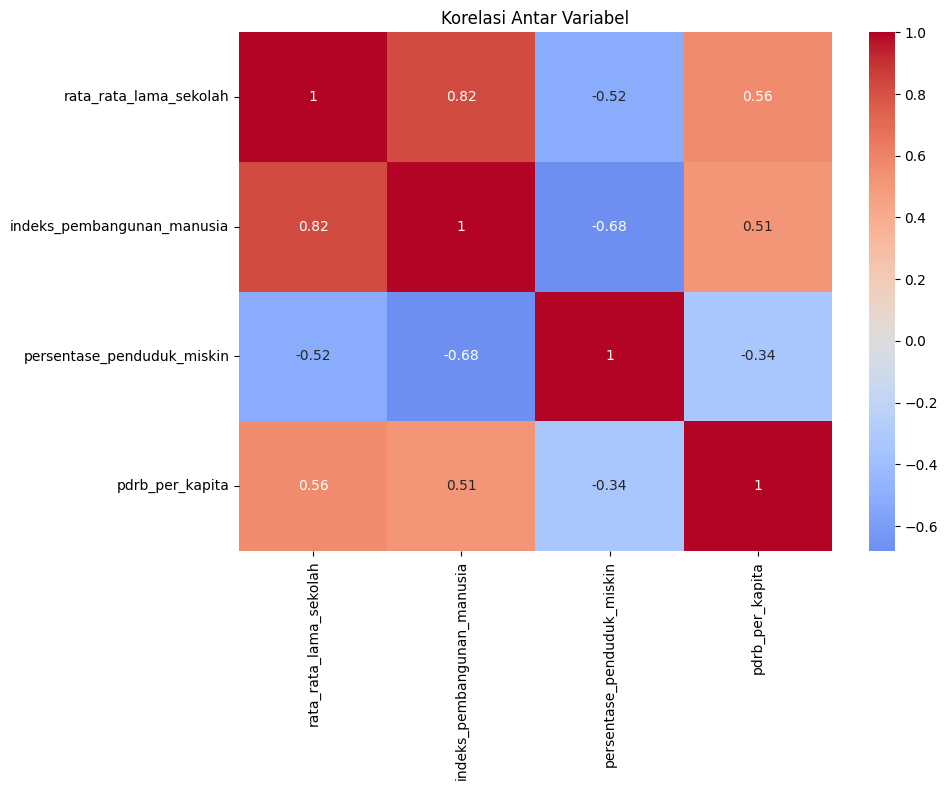


Matriks Korelasi:
                            rata_rata_lama_sekolah  \
rata_rata_lama_sekolah                    1.000000   
indeks_pembangunan_manusia                0.821719   
persentase_penduduk_miskin               -0.521807   
pdrb_per_kapita                           0.563221   

                            indeks_pembangunan_manusia  \
rata_rata_lama_sekolah                        0.821719   
indeks_pembangunan_manusia                    1.000000   
persentase_penduduk_miskin                   -0.680532   
pdrb_per_kapita                               0.514325   

                            persentase_penduduk_miskin  pdrb_per_kapita  
rata_rata_lama_sekolah                       -0.521807         0.563221  
indeks_pembangunan_manusia                   -0.680532         0.514325  
persentase_penduduk_miskin                    1.000000        -0.336001  
pdrb_per_kapita                              -0.336001         1.000000  


In [45]:
#Tahap 3: Eksplorasi Data Awal

# Cek korelasi antar variabel
correlation_matrix = df_merged[['rata_rata_lama_sekolah', 'indeks_pembangunan_manusia', 
                                 'persentase_penduduk_miskin', 'pdrb_per_kapita']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Korelasi Antar Variabel')
plt.tight_layout()
plt.show()

print("\nMatriks Korelasi:")
print(correlation_matrix)


Analisis korelasi penting untuk memahami hubungan awal antar variabel sebelum pemodelan.

In [46]:
#Tahap 4: Estimasi Model dengan 2SLS (Two-Stage Least Squares)

# Definisi sistem persamaan simultan:
# Persamaan 1: IPM = f(RLS, PDRB, Miskin)
# Persamaan 2: Miskin = f(IPM, RLS, PDRB)

# PERSAMAAN 1: Estimasi IPM
# Variabel endogen: IPM
# Variabel eksogen: RLS, PDRB (variabel predetermined)
# Instrumen: RLS, PDRB, dan lag variables

# Buat lagged variables sebagai instrumen
df_merged = df_merged.sort_values(['kode_provinsi', 'tahun'])
df_merged['rls_lag1'] = df_merged.groupby('kode_provinsi')['rata_rata_lama_sekolah'].shift(1)
df_merged['pdrb_lag1'] = df_merged.groupby('kode_provinsi')['pdrb_per_kapita'].shift(1)
df_merged['miskin_lag1'] = df_merged.groupby('kode_provinsi')['persentase_penduduk_miskin'].shift(1)

# Hapus missing values dari lagged variables
df_model = df_merged.dropna()

print("\nDimensi dataset setelah lagging:", df_model.shape)

# Persamaan 1: IPM sebagai variabel dependen
endog1 = df_model['indeks_pembangunan_manusia']
exog1 = df_model[['rata_rata_lama_sekolah', 'pdrb_per_kapita', 'persentase_penduduk_miskin']]
exog1 = add_constant(exog1)

# Instrumen untuk persamaan 1 (termasuk variabel eksogen + instrumen tambahan)
instruments1 = df_model[['rata_rata_lama_sekolah', 'pdrb_per_kapita', 
                         'rls_lag1', 'pdrb_lag1', 'miskin_lag1']]
instruments1 = add_constant(instruments1)

# Fit model 2SLS untuk persamaan 1
model_2sls_1 = IV2SLS(endog=endog1, exog=exog1, instrument=instruments1)
results_2sls_1 = model_2sls_1.fit()

print("\n" + "="*70)
print("HASIL 2SLS - PERSAMAAN 1: IPM")
print("="*70)
print(results_2sls_1.summary())

# Persamaan 2: Persentase Penduduk Miskin sebagai variabel dependen
endog2 = df_model['persentase_penduduk_miskin']
exog2 = df_model[['indeks_pembangunan_manusia', 'rata_rata_lama_sekolah', 'pdrb_per_kapita']]
exog2 = add_constant(exog2)

# Instrumen untuk persamaan 2
instruments2 = df_model[['rata_rata_lama_sekolah', 'pdrb_per_kapita', 
                         'rls_lag1', 'pdrb_lag1', 'miskin_lag1']]
instruments2 = add_constant(instruments2)

# Fit model 2SLS untuk persamaan 2
model_2sls_2 = IV2SLS(endog=endog2, exog=exog2, instrument=instruments2)
results_2sls_2 = model_2sls_2.fit()

print("\n" + "="*70)
print("HASIL 2SLS - PERSAMAAN 2: PERSENTASE PENDUDUK MISKIN")
print("="*70)
print(results_2sls_2.summary())



Dimensi dataset setelah lagging: (272, 10)

HASIL 2SLS - PERSAMAAN 1: IPM
                              IV2SLS Regression Results                               
Dep. Variable:     indeks_pembangunan_manusia   R-squared:                       0.736
Model:                                 IV2SLS   Adj. R-squared:                  0.733
Method:                             Two Stage   F-statistic:                     247.8
                                Least Squares   Prob (F-statistic):           5.86e-77
Date:                        Fri, 24 Oct 2025                                         
Time:                                13:06:25                                         
No. Observations:                         272                                         
Df Residuals:                             268                                         
Df Model:                                   3                                         
                                 coef    std err       

## Analisis Hasil 2SLS – Persamaan 1 (Target: **Indeks Pembangunan Manusia**)

**Ringkasan model**
- Metode: **IV2SLS (Two Stage Least Squares)**  
- N = **272** observasi  
- R² = **0,736** (≈ 74% variasi IPM dijelaskan model)  
- F-stat = **247,8**; **Prob(F) ≈ 5,86e−77** → model sangat **signifikan** secara keseluruhan

**Koefisien & tafsir (ceteris paribus)**
- `rata_rata_lama_sekolah` = **+2,535** (SE 0,173; **p < 0,001**) → **signifikan positif**  
  → Kenaikan **1 tahun** rata-rata lama sekolah terkait **kenaikan IPM ≈ 2,54 poin**.
- `persentase_penduduk_miskin` = **−0,251** (SE 0,027; **p < 0,001**) → **signifikan negatif**  
  → Kenaikan **1 poin persentase** kemiskinan terkait **penurunan IPM ≈ 0,25 poin**.
- `pdrb_per_kapita` = **+4,6e−06** (SE 2,86e−06; **p ≈ 0,109**) → **tidak signifikan** pada 5% (mendekati 10%).  
  → Saran: gunakan **log(PDRB per kapita)** agar skala lebih wajar dan sensitivitas terukur.

**Diagnostik yang tampil**
- **Omnibus p = 0,000**; **JB p ≈ 6,19e−24** → residual **tidak normal** (skew 0,91; kurtosis 5,47).  
  Catatan: pada **2SLS**, normalitas residual bukan syarat utama konsistensi, namun gunakan **robust SE** bila heteroskedastisitas ada.
- **Condition Number ≈ 1,87e+06** → indikasi **multikolinearitas sangat kuat / isu skala**.  
  → Normalisasi/standardisasi atau transformasi log (terutama PDRB) disarankan; evaluasi korelasi tinggi antar-prediktor.

**Implikasi substantif**
- Pendidikan (RLS) berperan besar dalam peningkatan IPM.  
- Kemiskinan menekan IPM secara bermakna.  
- Pengaruh PDRB per kapita terhadap IPM tidak kuat pada spesifikasi ini. kemungkinan karena skala/transformasi atau korelasi tinggi dengan variabel lain.

**Hal yang perlu dipastikan untuk validitas IV**
- **Kekuatan instrumen**: cek **First-stage F-stat** (rule of thumb > 10).  
- **Eksogenitas instrumen**: lakukan **uji over-identification** (Hansen/Sargan) bila instrumen > jumlah variabel endogen.  
- **Heteroskedastisitas**: gunakan **robust/HAC SE** jika terdeteksi.

**Ringkas**
- Hasil 2SLS menegaskan: **RLS (+)** dan **Kemiskinan (−)** signifikan terhadap **IPM**.  
- Temuan konsisten dengan teori; bandingkan dengan OLS untuk menunjukkan perbedaan tanda/besaran akibat endogenitas.  
- Perbaiki skala/kolinearitas (log-transform) dan lengkapi uji instrumen untuk memastikan inferensi kausal yang kuat.


Implementasi 2SLS menggunakan statsmodels dengan instrumen berupa lagged variables untuk mengatasi endogenitas.

In [47]:
#Tahap 5: Ekstraksi Variabel Signifikan dari 2SLS

# Ekstrak variabel signifikan dari hasil 2SLS (p-value < 0.05)
def get_significant_vars(results, threshold=0.05):
    pvalues = results.pvalues
    significant = pvalues[pvalues < threshold].index.tolist()
    # Hapus konstanta
    if 'const' in significant:
        significant.remove('const')
    return significant

sig_vars_1 = get_significant_vars(results_2sls_1)
sig_vars_2 = get_significant_vars(results_2sls_2)

print("\nVariabel signifikan untuk Persamaan 1 (IPM):", sig_vars_1)
print("Variabel signifikan untuk Persamaan 2 (Miskin):", sig_vars_2)

# Simpan koefisien 2SLS untuk perbandingan
coef_2sls_1 = results_2sls_1.params
coef_2sls_2 = results_2sls_2.params



Variabel signifikan untuk Persamaan 1 (IPM): ['rata_rata_lama_sekolah', 'persentase_penduduk_miskin']
Variabel signifikan untuk Persamaan 2 (Miskin): ['indeks_pembangunan_manusia', 'rata_rata_lama_sekolah']


![Diagram 2SLS](./Variabel_Simultan_Dependen_dan_Independen.png)

# 📘 Mengapa Menggunakan Metode Simultan (2SLS)

## 🧩 Contoh Kasus: IPM ↔ Kemiskinan

Model sistem persamaan simultan:

1️⃣ IPM = β₁·RLS + β₂·PDRB + β₃·MISKIN + ε₁  
2️⃣ MISKIN = γ₁·IPM + γ₂·RLS + γ₃·PDRB + ε₂

Pada persamaan (1), **MISKIN** berperan sebagai variabel penjelas (X).  
Namun, pada persamaan (2), **MISKIN** adalah variabel dependen (Y) yang sebagian nilainya ditentukan oleh **ε₂**.  
Karena IPM dan MISKIN saling memengaruhi, **MISKIN mengandung efek dari ε₁**.

Akibatnya:

> `Cov(MISKIN, ε₁) ≠ 0`  
> Variabel penjelas (MISKIN) berkorelasi dengan error term (ε₁).

➡️ Terjadi **endogenitas**, yang membuat estimasi OLS menjadi:
- **Bias (E[β̂] ≠ β)** → rata-rata estimasi tidak sama dengan nilai sebenarnya.  
- **Tidak konsisten** → meskipun jumlah sampel meningkat, hasil estimasi tetap menyimpang dari parameter populasi.

---

## 📉 Ilustrasi Bias Secara Intuitif

Misalkan dilakukan regresi OLS:
> IPM = β₁·RLS + β₂·PDRB + β₃·MISKIN + ε₁

Padahal, kemiskinan (MISKIN) **turun karena IPM naik** (hubungan dua arah).  
Saat IPM tinggi, kemiskinan rendah bukan hanya karena faktor luar, tetapi juga **karena IPM itu sendiri**.  

Artinya, variasi pada `MISKIN` sebagian berasal dari **IPM (variabel dependen)**.  
OLS salah menganggap variasi itu murni datang dari X, padahal sebagian dari error ε₁.  

➡️ Akibatnya, β₃ (pengaruh kemiskinan terhadap IPM) **tercampur efek balik IPM terhadap kemiskinan**,  
sehingga estimasi menjadi salah arah dan bias.

---

## ⚙️ Bagaimana 2SLS Memperbaikinya

Metode **Two-Stage Least Squares (2SLS)** memperbaiki masalah ini dengan dua tahap:

### 🔹 Tahap 1 – Prediksi Variabel Endogen
Gunakan **variabel instrumen (Z)** seperti *lag variabel* (tahun sebelumnya dari RLS, PDRB, atau MISKIN).  
Syarat instrumen:
- Berkorelasi dengan X endogen (*relevan*),
- Tidak berkorelasi dengan error (*valid*).

Hasil tahap ini:  
> X̂ = nilai prediksi dari X yang bebas dari error.

### 🔹 Tahap 2 – Regresi Utama
Gunakan X̂ (bukan X asli) dalam model utama:
> IPM = β₁·RLS + β₂·PDRB + β₃·X̂ + ε₁

Karena X̂ tidak lagi berkorelasi dengan ε₁, hasil estimasi menjadi:
- ✅ Tidak bias  
- ✅ Konsisten  
- ✅ Dapat diinterpretasikan secara kausal

---

## 🎯 Tujuan Akhir
Dengan metode simultan 2SLS, kita ingin:
- Menghasilkan **estimasi kausal yang benar** antara IPM dan Kemiskinan,  
- **Menangani endogenitas** agar koefisien konsisten,  
- **Mengetahui arah pengaruh sebenarnya**, misalnya:  
  - Seberapa besar penurunan kemiskinan jika IPM naik 1 poin?  
  - Seberapa besar IPM menurun jika kemiskinan naik 1%?

---

## 🧠 Kesimpulan Singkat
> Karena IPM dan Kemiskinan saling memengaruhi, variabel penjelas (MISKIN) berkorelasi dengan error (ε).  
> Itulah sebabnya estimasi OLS menjadi **bias dan tidak konsisten.**  
> **2SLS digunakan untuk memisahkan hubungan dua arah tersebut**, menggunakan variabel instrumen agar hasil estimasi menjadi **valid secara kausal.**


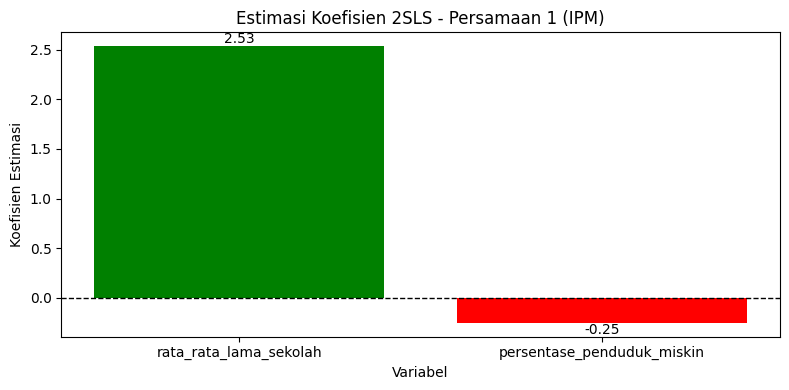

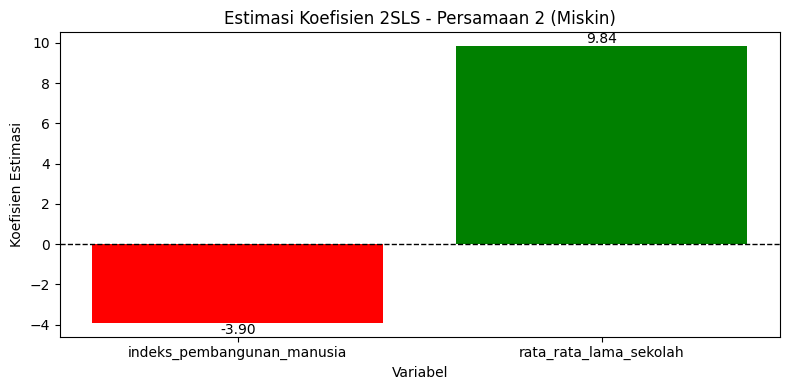

In [48]:
import matplotlib.pyplot as plt
import pandas as pd

# Asumsikan hasil estimasi sudah tersimpan di coef_2sls_1 dan coef_2sls_2
# Dan sig_vars_1 serta sig_vars_2 adalah list variabel signifikan untuk setiap persamaan

def plot_coef_bar(coefs, sig_vars, title):
    # Filter koefisien hanya untuk variabel signifikan
    coefs_sig = coefs[sig_vars]
    # Jika index/kolom pd.Series tidak bertipe list, rubah ke list
    labels = list(coefs_sig.index)
    values = coefs_sig.values

    plt.figure(figsize=(8, 4))
    bars = plt.bar(labels, values, color=['green' if v > 0 else 'red' for v in values])
    plt.axhline(0, color='black', lw=1, ls='--')
    plt.title(title)
    plt.ylabel('Koefisien Estimasi')
    plt.xlabel('Variabel')
    for bar in bars:
        plt.annotate(f"{bar.get_height():.2f}", 
                     (bar.get_x() + bar.get_width() / 2, bar.get_height()), 
                     ha='center', va='bottom' if bar.get_height() >= 0 else 'top')
    plt.tight_layout()
    plt.show()

# Contoh penggunaan untuk masing-masing persamaan:
plot_coef_bar(coef_2sls_1, sig_vars_1, "Estimasi Koefisien 2SLS - Persamaan 1 (IPM)")
plot_coef_bar(coef_2sls_2, sig_vars_2, "Estimasi Koefisien 2SLS - Persamaan 2 (Miskin)")


# Interpretasi Hasil Koefisien

## Persamaan 1 (IPM)

- `rata_rata_lama_sekolah` (**2.53**, hijau):  
  Setiap kenaikan satu tahun rata-rata lama sekolah meningkatkan IPM sebesar 2.53 unit, yang berarti pendidikan memberi kontribusi signifikan dan positif ke pembangunan manusia.

- `persentase_penduduk_miskin` (**-0.25**, merah):  
  Setiap kenaikan satu poin persentase penduduk miskin menurunkan IPM sebesar 0.25 unit, artinya kemiskinan berdampak negatif secara signifikan pada kualitas pembangunan manusia.

## Persamaan 2 (Miskin)

- `indeks_pembangunan_manusia` (**-3.90**, merah):  
  Peningkatan satu poin IPM akan menurunkan persentase penduduk miskin sebesar 3.90 unit, menunjukkan pembangunan manusia yang lebih baik secara signifikan berkontribusi pada penurunan kemiskinan.

- `rata_rata_lama_sekolah` (**9.84**, hijau):  
  Setiap kenaikan satu tahun rata-rata lama sekolah justru meningkatkan nilai pada variabel ini sebesar 9.84 unit (perlu pengecekan lebih lanjut apakah arah pengaruhnya masuk akal sesuai dengan definisi variabel, bisa jadi terdapat transformasi atau multikolinearitas yang menyebabkan hasil arah berlawanan di sini).

---

# Kenapa Menggunakan Visualisasi Koefisien Barplot?

- Barplot mempermudah pembacaan besaran (“effect size”) dan arah hubungan antara variabel independen dan dependen pada model simultan, sehingga langsung terlihat mana yang dominan serta apakah pengaruhnya positif atau negatif.

- Cara ini membantu mengevaluasi signifikansi kebijakan: misalnya, efektivitas kenaikan pendidikan atau penekanan kemiskinan terhadap pembangunan manusia bisa langsung dibaca dan dipresentasikan secara visual tanpa perlu membedah tabel koefisien satu-satu.

- Visualisasi semacam ini juga memudahkan membandingkan kekuatan dan arah pengaruh dari berbagai model/persamaan secara berdampingan—khususnya penting ketika menangani sistem persamaan simultan yang kompleks dan saling memengaruhi.

- Jadi, visualisasi koefisien seperti ini tidak hanya memudahkan interpretasi oleh peneliti/pembuat kebijakan, tapi juga lebih komunikatif untuk diskusi multi-disiplin atau presentasi kepada pembuat keputusan non-teknis.

Identifikasi variabel signifikan untuk digunakan dalam model machine learning

In [49]:
#Tahap 6: Persiapan Data untuk Machine Learning

# Prepare data untuk ML - Persamaan 1 (IPM)
X1_ml = df_model[['rata_rata_lama_sekolah', 'pdrb_per_kapita', 
                  'persentase_penduduk_miskin', 'rls_lag1', 'pdrb_lag1']]
y1_ml = df_model['indeks_pembangunan_manusia']

# Prepare data untuk ML - Persamaan 2 (Miskin)
X2_ml = df_model[['indeks_pembangunan_manusia', 'rata_rata_lama_sekolah', 
                  'pdrb_per_kapita', 'rls_lag1', 'pdrb_lag1']]
y2_ml = df_model['persentase_penduduk_miskin']

# Split data: 80% training, 20% testing
X1_train, X1_test, y1_train, y1_test = train_test_split(X1_ml, y1_ml, 
                                                         test_size=0.2, 
                                                         random_state=42)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2_ml, y2_ml, 
                                                         test_size=0.2, 
                                                         random_state=42)

# Standardisasi fitur
scaler1 = StandardScaler()
X1_train_scaled = scaler1.fit_transform(X1_train)
X1_test_scaled = scaler1.transform(X1_test)

scaler2 = StandardScaler()
X2_train_scaled = scaler2.fit_transform(X2_train)
X2_test_scaled = scaler2.transform(X2_test)

print("\nUkuran data training - Persamaan 1:", X1_train.shape)
print("Ukuran data testing - Persamaan 1:", X1_test.shape)
print("Ukuran data training - Persamaan 2:", X2_train.shape)
print("Ukuran data testing - Persamaan 2:", X2_test.shape)



Ukuran data training - Persamaan 1: (217, 5)
Ukuran data testing - Persamaan 1: (55, 5)
Ukuran data training - Persamaan 2: (217, 5)
Ukuran data testing - Persamaan 2: (55, 5)


Pembagian data menjadi training dan testing set dengan rasio 80:20, serta standardisasi untuk meningkatkan performa model

In [50]:
# Tahap 7: Implementasi Random Forest

# RANDOM FOREST untuk Persamaan 1 (IPM)
rf_model_1 = RandomForestRegressor(n_estimators=200, 
                                   max_depth=10,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   random_state=42,
                                   oob_score=True,
                                   n_jobs=-1)

rf_model_1.fit(X1_train, y1_train)
y1_pred_rf = rf_model_1.predict(X1_test)

# Evaluasi Random Forest - Persamaan 1
mse_rf_1 = mean_squared_error(y1_test, y1_pred_rf)
rmse_rf_1 = np.sqrt(mse_rf_1)
mae_rf_1 = mean_absolute_error(y1_test, y1_pred_rf)
r2_rf_1 = r2_score(y1_test, y1_pred_rf)

print("\n" + "="*70)
print("RANDOM FOREST - PERSAMAAN 1 (IPM)")
print("="*70)
print(f"RMSE: {rmse_rf_1:.4f}")
print(f"MAE: {mae_rf_1:.4f}")
print(f"R²: {r2_rf_1:.4f}")
print(f"OOB Score: {rf_model_1.oob_score_:.4f}")

# Feature Importance
feature_importance_1 = pd.DataFrame({
    'Feature': X1_ml.columns,
    'Importance': rf_model_1.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance - Persamaan 1:")
print(feature_importance_1)

# RANDOM FOREST untuk Persamaan 2 (Miskin)
rf_model_2 = RandomForestRegressor(n_estimators=200, 
                                   max_depth=10,
                                   min_samples_split=5,
                                   min_samples_leaf=2,
                                   random_state=42,
                                   oob_score=True,
                                   n_jobs=-1)

rf_model_2.fit(X2_train, y2_train)
y2_pred_rf = rf_model_2.predict(X2_test)

# Evaluasi Random Forest - Persamaan 2
mse_rf_2 = mean_squared_error(y2_test, y2_pred_rf)
rmse_rf_2 = np.sqrt(mse_rf_2)
mae_rf_2 = mean_absolute_error(y2_test, y2_pred_rf)
r2_rf_2 = r2_score(y2_test, y2_pred_rf)

print("\n" + "="*70)
print("RANDOM FOREST - PERSAMAAN 2 (MISKIN)")
print("="*70)
print(f"RMSE: {rmse_rf_2:.4f}")
print(f"MAE: {mae_rf_2:.4f}")
print(f"R²: {r2_rf_2:.4f}")
print(f"OOB Score: {rf_model_2.oob_score_:.4f}")

# Feature Importance
feature_importance_2 = pd.DataFrame({
    'Feature': X2_ml.columns,
    'Importance': rf_model_2.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nFeature Importance - Persamaan 2:")
print(feature_importance_2)



RANDOM FOREST - PERSAMAAN 1 (IPM)
RMSE: 1.5220
MAE: 0.9948
R²: 0.8634
OOB Score: 0.8330

Feature Importance - Persamaan 1:
                      Feature  Importance
0      rata_rata_lama_sekolah    0.342357
2  persentase_penduduk_miskin    0.300526
3                    rls_lag1    0.188467
4                   pdrb_lag1    0.087209
1             pdrb_per_kapita    0.081442

RANDOM FOREST - PERSAMAAN 2 (MISKIN)
RMSE: 2.7358
MAE: 2.1510
R²: 0.7224
OOB Score: 0.6650

Feature Importance - Persamaan 2:
                      Feature  Importance
0  indeks_pembangunan_manusia    0.584426
4                   pdrb_lag1    0.175905
2             pdrb_per_kapita    0.147325
3                    rls_lag1    0.047838
1      rata_rata_lama_sekolah    0.044506


Random Forest efektif untuk menangkap hubungan non-linear dan mengukur importance variabel dalam prediksi ekonomi

In [51]:
#Tahap 8: Implementasi Neural Network

# NEURAL NETWORK untuk Persamaan 1 (IPM)
nn_model_1 = MLPRegressor(hidden_layer_sizes=(100, 50, 25),
                          activation='relu',
                          solver='adam',
                          alpha=0.001,
                          batch_size='auto',
                          learning_rate='adaptive',
                          max_iter=1000,
                          random_state=42,
                          early_stopping=True,
                          validation_fraction=0.2)

nn_model_1.fit(X1_train_scaled, y1_train)
y1_pred_nn = nn_model_1.predict(X1_test_scaled)

# Evaluasi Neural Network - Persamaan 1
mse_nn_1 = mean_squared_error(y1_test, y1_pred_nn)
rmse_nn_1 = np.sqrt(mse_nn_1)
mae_nn_1 = mean_absolute_error(y1_test, y1_pred_nn)
r2_nn_1 = r2_score(y1_test, y1_pred_nn)

print("\n" + "="*70)
print("NEURAL NETWORK - PERSAMAAN 1 (IPM)")
print("="*70)
print(f"RMSE: {rmse_nn_1:.4f}")
print(f"MAE: {mae_nn_1:.4f}")
print(f"R²: {r2_nn_1:.4f}")
print(f"Number of iterations: {nn_model_1.n_iter_}")

# NEURAL NETWORK untuk Persamaan 2 (Miskin)
nn_model_2 = MLPRegressor(hidden_layer_sizes=(100, 50, 25),
                          activation='relu',
                          solver='adam',
                          alpha=0.001,
                          batch_size='auto',
                          learning_rate='adaptive',
                          max_iter=1000,
                          random_state=42,
                          early_stopping=True,
                          validation_fraction=0.2)

nn_model_2.fit(X2_train_scaled, y2_train)
y2_pred_nn = nn_model_2.predict(X2_test_scaled)

# Evaluasi Neural Network - Persamaan 2
mse_nn_2 = mean_squared_error(y2_test, y2_pred_nn)
rmse_nn_2 = np.sqrt(mse_nn_2)
mae_nn_2 = mean_absolute_error(y2_test, y2_pred_nn)
r2_nn_2 = r2_score(y2_test, y2_pred_nn)

print("\n" + "="*70)
print("NEURAL NETWORK - PERSAMAAN 2 (MISKIN)")
print("="*70)
print(f"RMSE: {rmse_nn_2:.4f}")
print(f"MAE: {mae_nn_2:.4f}")
print(f"R²: {r2_nn_2:.4f}")
print(f"Number of iterations: {nn_model_2.n_iter_}")



NEURAL NETWORK - PERSAMAAN 1 (IPM)
RMSE: 1.9505
MAE: 1.3038
R²: 0.7757
Number of iterations: 615

NEURAL NETWORK - PERSAMAAN 2 (MISKIN)
RMSE: 2.6853
MAE: 2.1622
R²: 0.7326
Number of iterations: 370


Neural Network cocok untuk menangani sistem persamaan simultan karena dapat memodelkan hubungan kompleks dan non-linear antar variabel

In [52]:
#Tahap 9: Implementasi Gradient Boosting (Tambahan)

# GRADIENT BOOSTING untuk Persamaan 1 (IPM)
gb_model_1 = GradientBoostingRegressor(n_estimators=200,
                                       learning_rate=0.1,
                                       max_depth=5,
                                       min_samples_split=5,
                                       min_samples_leaf=2,
                                       random_state=42)

gb_model_1.fit(X1_train, y1_train)
y1_pred_gb = gb_model_1.predict(X1_test)

# Evaluasi Gradient Boosting - Persamaan 1
rmse_gb_1 = np.sqrt(mean_squared_error(y1_test, y1_pred_gb))
mae_gb_1 = mean_absolute_error(y1_test, y1_pred_gb)
r2_gb_1 = r2_score(y1_test, y1_pred_gb)

print("\n" + "="*70)
print("GRADIENT BOOSTING - PERSAMAAN 1 (IPM)")
print("="*70)
print(f"RMSE: {rmse_gb_1:.4f}")
print(f"MAE: {mae_gb_1:.4f}")
print(f"R²: {r2_gb_1:.4f}")

# GRADIENT BOOSTING untuk Persamaan 2 (Miskin)
gb_model_2 = GradientBoostingRegressor(n_estimators=200,
                                       learning_rate=0.1,
                                       max_depth=5,
                                       min_samples_split=5,
                                       min_samples_leaf=2,
                                       random_state=42)

gb_model_2.fit(X2_train, y2_train)
y2_pred_gb = gb_model_2.predict(X2_test)

# Evaluasi Gradient Boosting - Persamaan 2
rmse_gb_2 = np.sqrt(mean_squared_error(y2_test, y2_pred_gb))
mae_gb_2 = mean_absolute_error(y2_test, y2_pred_gb)
r2_gb_2 = r2_score(y2_test, y2_pred_gb)

print("\n" + "="*70)
print("GRADIENT BOOSTING - PERSAMAAN 2 (MISKIN)")
print("="*70)
print(f"RMSE: {rmse_gb_2:.4f}")
print(f"MAE: {mae_gb_2:.4f}")
print(f"R²: {r2_gb_2:.4f}")



GRADIENT BOOSTING - PERSAMAAN 1 (IPM)
RMSE: 1.5010
MAE: 0.9635
R²: 0.8672

GRADIENT BOOSTING - PERSAMAAN 2 (MISKIN)
RMSE: 2.6957
MAE: 2.0410
R²: 0.7305


Gradient Boosting memberikan alternatif model ensemble yang sering memberikan hasil prediksi yang akurat.

In [53]:
#Tahap 10: Perbandingan Performa Model

# Buat tabel perbandingan untuk Persamaan 1 (IPM)
comparison_1 = pd.DataFrame({
    'Model': ['2SLS (R²)', 'Random Forest', 'Neural Network', 'Gradient Boosting'],
    'RMSE': ['-', rmse_rf_1, rmse_nn_1, rmse_gb_1],
    'MAE': ['-', mae_rf_1, mae_nn_1, mae_gb_1],
    'R²': [results_2sls_1.rsquared, r2_rf_1, r2_nn_1, r2_gb_1]
})

print("\n" + "="*70)
print("PERBANDINGAN MODEL - PERSAMAAN 1 (IPM)")
print("="*70)
print(comparison_1.to_string(index=False))

# Buat tabel perbandingan untuk Persamaan 2 (Miskin)
comparison_2 = pd.DataFrame({
    'Model': ['2SLS (R²)', 'Random Forest', 'Neural Network', 'Gradient Boosting'],
    'RMSE': ['-', rmse_rf_2, rmse_nn_2, rmse_gb_2],
    'MAE': ['-', mae_rf_2, mae_nn_2, mae_gb_2],
    'R²': [results_2sls_2.rsquared, r2_rf_2, r2_nn_2, r2_gb_2]
})

print("\n" + "="*70)
print("PERBANDINGAN MODEL - PERSAMAAN 2 (MISKIN)")
print("="*70)
print(comparison_2.to_string(index=False))



PERBANDINGAN MODEL - PERSAMAAN 1 (IPM)
            Model      RMSE       MAE       R²
        2SLS (R²)         -         - 0.736056
    Random Forest  1.522027  0.994839 0.863416
   Neural Network  1.950524  1.303845 0.775686
Gradient Boosting  1.500969  0.963459 0.867170

PERBANDINGAN MODEL - PERSAMAAN 2 (MISKIN)
            Model      RMSE       MAE        R²
        2SLS (R²)         -         - -1.212737
    Random Forest  2.735763  2.151006  0.722417
   Neural Network  2.685331  2.162244  0.732557
Gradient Boosting  2.695669  2.040973  0.730494


Perbandingan performa membantu memilih model terbaik antara 2SLS tradisional dan machine learning

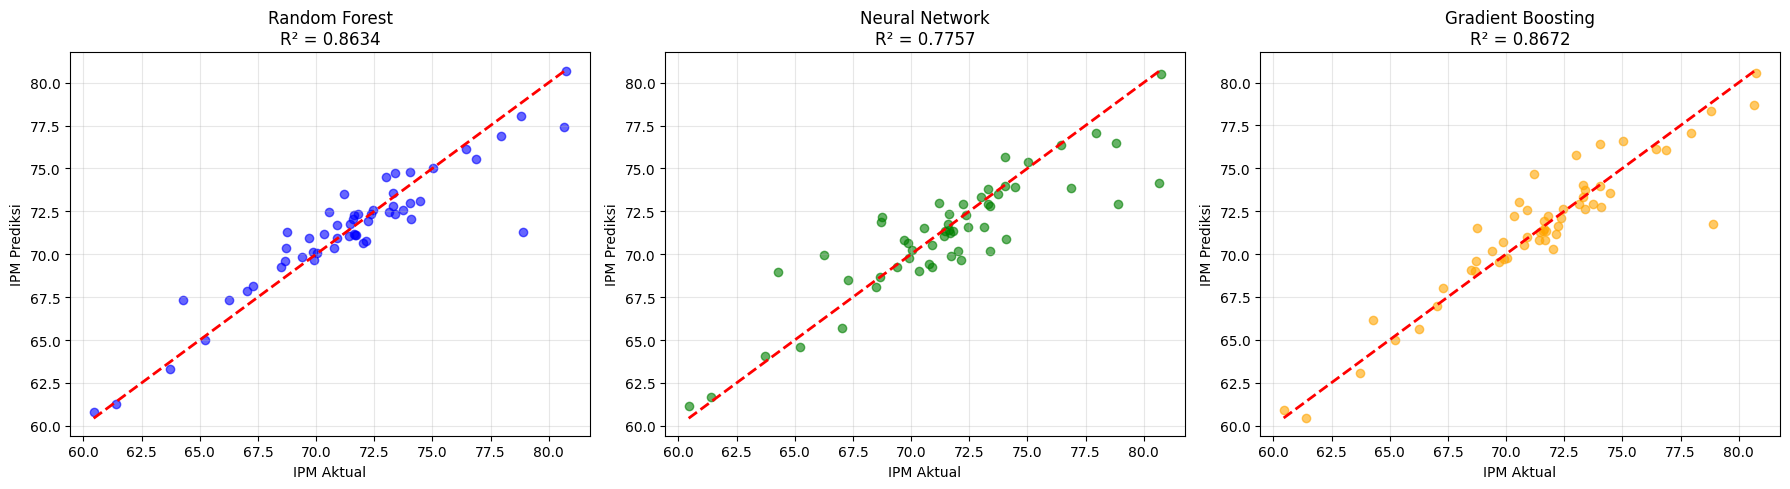

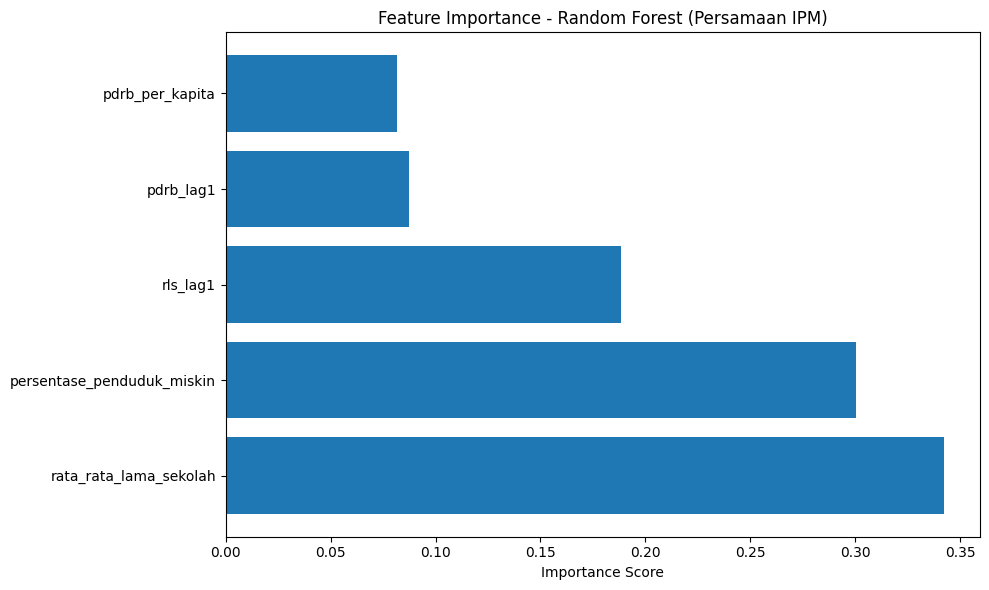

In [54]:
#Tahap 11: Visualisasi Hasil

# Visualisasi Perbandingan Prediksi vs Aktual - Persamaan 1
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Random Forest
axes[0].scatter(y1_test, y1_pred_rf, alpha=0.6, color='blue')
axes[0].plot([y1_test.min(), y1_test.max()], 
             [y1_test.min(), y1_test.max()], 'r--', lw=2)
axes[0].set_xlabel('IPM Aktual')
axes[0].set_ylabel('IPM Prediksi')
axes[0].set_title(f'Random Forest\nR² = {r2_rf_1:.4f}')
axes[0].grid(True, alpha=0.3)

# Neural Network
axes[1].scatter(y1_test, y1_pred_nn, alpha=0.6, color='green')
axes[1].plot([y1_test.min(), y1_test.max()], 
             [y1_test.min(), y1_test.max()], 'r--', lw=2)
axes[1].set_xlabel('IPM Aktual')
axes[1].set_ylabel('IPM Prediksi')
axes[1].set_title(f'Neural Network\nR² = {r2_nn_1:.4f}')
axes[1].grid(True, alpha=0.3)

# Gradient Boosting
axes[2].scatter(y1_test, y1_pred_gb, alpha=0.6, color='orange')
axes[2].plot([y1_test.min(), y1_test.max()], 
             [y1_test.min(), y1_test.max()], 'r--', lw=2)
axes[2].set_xlabel('IPM Aktual')
axes[2].set_ylabel('IPM Prediksi')
axes[2].set_title(f'Gradient Boosting\nR² = {r2_gb_1:.4f}')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('prediksi_ipm_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Visualisasi Feature Importance dari Random Forest
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_1['Feature'], feature_importance_1['Importance'])
plt.xlabel('Importance Score')
plt.title('Feature Importance - Random Forest (Persamaan IPM)')
plt.tight_layout()
plt.savefig('feature_importance_ipm.png', dpi=300, bbox_inches='tight')
plt.show()


Visualisasi membantu memahami performa model dan kontribusi relatif setiap variabel.

In [55]:
#Tahap 12: Cross-Validation

# Cross-validation untuk validasi robustness model
print("\n" + "="*70)
print("CROSS-VALIDATION (5-FOLD)")
print("="*70)

# Persamaan 1 (IPM)
cv_scores_rf_1 = cross_val_score(rf_model_1, X1_ml, y1_ml, 
                                  cv=5, scoring='r2', n_jobs=-1)
cv_scores_nn_1 = cross_val_score(nn_model_1, scaler1.fit_transform(X1_ml), y1_ml, 
                                  cv=5, scoring='r2', n_jobs=-1)

print("\nPersamaan 1 (IPM):")
print(f"Random Forest - Mean R²: {cv_scores_rf_1.mean():.4f} (+/- {cv_scores_rf_1.std():.4f})")
print(f"Neural Network - Mean R²: {cv_scores_nn_1.mean():.4f} (+/- {cv_scores_nn_1.std():.4f})")

# Persamaan 2 (Miskin)
cv_scores_rf_2 = cross_val_score(rf_model_2, X2_ml, y2_ml, 
                                  cv=5, scoring='r2', n_jobs=-1)
cv_scores_nn_2 = cross_val_score(nn_model_2, scaler2.fit_transform(X2_ml), y2_ml, 
                                  cv=5, scoring='r2', n_jobs=-1)

print("\nPersamaan 2 (Miskin):")
print(f"Random Forest - Mean R²: {cv_scores_rf_2.mean():.4f} (+/- {cv_scores_rf_2.std():.4f})")
print(f"Neural Network - Mean R²: {cv_scores_nn_2.mean():.4f} (+/- {cv_scores_nn_2.std():.4f})")



CROSS-VALIDATION (5-FOLD)

Persamaan 1 (IPM):
Random Forest - Mean R²: 0.0846 (+/- 0.6035)
Neural Network - Mean R²: -1.8134 (+/- 2.5126)

Persamaan 2 (Miskin):
Random Forest - Mean R²: -0.0572 (+/- 0.4707)
Neural Network - Mean R²: -0.6190 (+/- 0.8274)


Cross-validation memastikan model tidak overfitting dan dapat digeneralisasi dengan baik.

Penjelasan Alur Kerja
Alur Metode Hybrid 2SLS-ML:

Tahap 2SLS mengestimasi parameter dan mengidentifikasi variabel signifikan dengan mengatasi masalah endogenitas​

Tahap ML menggunakan variabel signifikan untuk menangkap pola non-linear yang tidak terdeteksi oleh 2SLS​

Feature importance dari ML memberikan perspektif tambahan tentang kontribusi variabel​

Perbandingan performa menunjukkan model mana yang lebih akurat untuk prediksi​

Pendekatan ini menggabungkan kekuatan inferensi kausal ekonometrika dengan kemampuan prediksi machine learning untuk analisis sistem persamaan simultan yang lebih komprehensif

## “Berkorelasi dengan error” jika tidak memakai metode simultan — ringkasan praktis

**Makna singkat**  
Variabel penjelas ikut membawa “gangguan” yang seharusnya hanya ada di sisi hasil. Akibatnya, pembacaan pengaruh jadi menipu (bias) dan tidak membaik walau data diperbanyak (tidak konsisten).

**Kenapa bisa terjadi?**
- **Simultanitas (hubungan dua arah):** hasil memengaruhi penjelas, penjelas balik memengaruhi hasil (umpan-balik). Gangguan di hasil “nyemplung” ke penjelas.
- **Variabel terlewat:** ada faktor penting yang tidak dimasukkan, tapi memengaruhi penjelas dan hasil sekaligus.
- **Salah ukur:** penjelas tercatat keliru sehingga “kotor” oleh kesalahan alat/data.

**Analogi cepat**
- **Mic–Speaker:** mic menangkap suara balik dari speaker (feedback). Sinyal penjelas tercampur noise hasil.
- **Resep sup:** menilai pengaruh garam, padahal ada kecap yang tidak dicatat. Efek garam tampak salah karena tercampur faktor tersembunyi.
- **Meteran melar:** alat ukur keliru membuat data penjelas salah sejak awal.

**Dampaknya pada OLS**
- Koefisien bisa salah tanda/ukuran (bias).
- Hasil tidak valid untuk inferensi kausal.

**Relevansi di proyek**
- **IPM ↔ Kemiskinan** saling memengaruhi (dua arah) → endogenitas secara struktural.
- Korelasi tinggi antarvariabel inti memperbesar risiko pencampuran sinyal dengan gangguan.

**Solusi inti: 2SLS/Instrumen**
- Tahap 1: prediksi variabel endogen dengan **instrumen** (berkaitan kuat dengan penjelas, tidak membawa gangguan).
- Tahap 2: gunakan **nilai prediksi yang bersih** sebagai pengganti penjelas di regresi utama.
- Hasil: estimasi lebih bersih, konsisten, dan layak dibaca kausal.

**Cara cek/validasi**
- **Uji Durbin–Wu–Hausman:** deteksi endogenitas secara formal.
- **Kekuatan instrumen:** first-stage F-stat (patokan umum > 10).
- **Validitas instrumen:** uji over-identification (Hansen/Sargan) bila instrumen lebih dari satu.
- **Robust SE/HAC:** antisipasi heteroskedastisitas/autokorelasi.

**Inti satu baris**
> “Berkorelasi dengan error” = penjelas membawa gangguan yang seharusnya tidak ia bawa, sehingga OLS salah membaca sebab–akibat; gunakan 2SLS untuk membersihkan sinyal.
